# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
!mkdir -p data
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.67KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

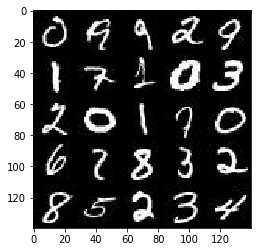

In [2]:
show_n_images = 25
data_dir = './data'
import helper

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

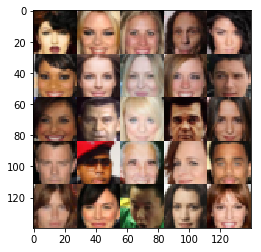

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name="real_input")
    z_input = tf.placeholder(tf.float32, [None, z_dim], name="z_input")
    l_rate = tf.placeholder(tf.float32, name="l_rate")

    return real_input, z_input, l_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [13]:
import numpy as np
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse):        
        #Input is 28x28x3
        x = tf.layers.conv2d(images, filters=32, kernel_size=4, strides=1, padding="same")
        x = tf.maximum(alpha * x, x, "input")
        # 28x28x32
        
        #print(x.shape)
        
        cl0 = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=2, padding="same")
        cl0 = tf.layers.batch_normalization(cl0, training=True)
        cl0 = tf.maximum(alpha * cl0, cl0, "cl0")
        # 14x14x64
        
        cl1 = tf.layers.conv2d(cl0, filters=128, kernel_size=4, strides=2, padding="same")
        cl1 = tf.layers.batch_normalization(cl1, training=True)
        cl1 = tf.maximum(alpha * cl1, cl1, "cl1")
        # 7x7x128
        
        #print(cl1.shape)
        
        cl2 = tf.layers.conv2d(cl1, filters=256, kernel_size=4, strides=2, padding="same")
        cl2 = tf.layers.batch_normalization(cl2, training=True)
        cl2 = tf.maximum(alpha * cl2, cl2, "cl2")
        # 4x4x256
        
        #print(cl2.shape)
        
        cl3 = tf.layers.conv2d(cl2, filters=512, kernel_size=4, strides=2, padding="same")
        cl3 = tf.layers.batch_normalization(cl3, training=True)
        cl3 = tf.maximum(alpha * cl3, cl3, "cl3")
        # 2x2x512
        
        #print(cl3.shape)
        
        #cl4 = tf.layers.conv2d(cl3, filters=512, kernel_size=4, strides=2, padding="same")
        #cl4 = tf.layers.batch_normalization(cl4, training=True)
        #cl4 = tf.maximum(alpha * cl4, cl4, "cl4")
        # 7x7x512

        # Flatten it
        flat = tf.reshape(cl3, (-1, int(np.prod(cl3.shape[1:]))))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [16]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function

    with tf.variable_scope("generator", reuse=not is_train):
        # First fully connected layer
        x = tf.layers.dense(z, 7*7*512)
        x = tf.reshape(x, (-1, 7, 7, 512))
        x = tf.layers.batch_normalization(x, training=not is_train)
        # Leaky ReLU
        x = tf.maximum(alpha * x, x, "input")
        # 7x7x512 now
        
        cl1 = tf.layers.conv2d_transpose(x, 256, 4, 2, 'same')
        cl1 = tf.layers.batch_normalization(cl1, training=not is_train)
        cl1 = tf.maximum(alpha * cl1, cl1, "cl1")
        # 14x14x256 now
        
        #print(cl1.shape)
        
        cl2 = tf.layers.conv2d_transpose(cl1, 128, 4, 2, 'same')
        cl2 = tf.layers.batch_normalization(cl2, training=not is_train)
        cl2 = tf.maximum(alpha * cl2, cl2, "cl2")
        # 28x28x128 now
        
        #print(cl2.shape)
        
        #cl3 = tf.layers.conv2d_transpose(cl2, 32, 4, 1, 'valid')
        #cl3 = tf.layers.batch_normalization(cl3, training=not is_train)
        #cl3 = tf.maximum(alpha * cl3, cl3, "cl3")
        # 7x7x32 now
        
        #print(cl3.shape)
        
        #cl4 = tf.layers.conv2d_transpose(cl3, 16, 5, 2, 'same')
        #cl4 = tf.layers.batch_normalization(cl4, training=not is_train)
        #cl4 = tf.maximum(alpha * cl4, cl4, "cl3")
        # 14x14x16 now
        
        # Output layer, 28x28xout_channel_dim
        logits = tf.layers.conv2d_transpose(cl2, out_channel_dim, 4, 1, 'same')
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function 
    # Taken as is from the DCGAN lesson
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    # Taken as is from the DCGAN lesson
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,
                           print_every = 10, draw_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    losses = []
    
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    
    if data_image_mode == "RGB":
        channels = 3
    elif data_image_mode == "L":
        channels = 1
    else:
        assert False, "Image mode not recognised."
        
    steps = 0
   
    # Building the Model
    real_input, z_input, l_rate = model_inputs(data_shape[1], data_shape[2], channels, z_dim)
    d_loss, g_loss = model_loss(real_input, z_input, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, l_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                batch_images = batch_images * 2
                # TODO: Train Model               
                
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={real_input: batch_images, z_input: batch_z, l_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={z_input: batch_z, real_input: batch_images, l_rate: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({z_input: batch_z, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: batch_z})
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % draw_every == 0:
                    show_generator_output(sess, 25, z_input, channels, data_image_mode)
           
        show_generator_output(sess, 25, z_input, channels, data_image_mode)    
        
        return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.7846... Generator Loss: 1.3012
Epoch 1/2... Discriminator Loss: 0.0726... Generator Loss: 3.2797
Epoch 1/2... Discriminator Loss: 0.0841... Generator Loss: 4.5968
Epoch 1/2... Discriminator Loss: 2.4877... Generator Loss: 2.8476
Epoch 1/2... Discriminator Loss: 2.1401... Generator Loss: 4.0486
Epoch 1/2... Discriminator Loss: 3.9829... Generator Loss: 0.0261
Epoch 1/2... Discriminator Loss: 0.7628... Generator Loss: 1.1381
Epoch 1/2... Discriminator Loss: 1.4058... Generator Loss: 1.0284
Epoch 1/2... Discriminator Loss: 2.0104... Generator Loss: 0.1630
Epoch 1/2... Discriminator Loss: 2.6595... Generator Loss: 2.4139


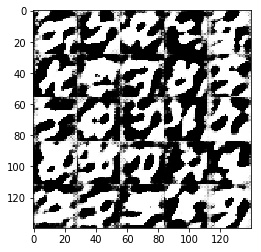

Epoch 1/2... Discriminator Loss: 1.0228... Generator Loss: 0.8034
Epoch 1/2... Discriminator Loss: 1.0958... Generator Loss: 0.5949
Epoch 1/2... Discriminator Loss: 0.9718... Generator Loss: 0.7999
Epoch 1/2... Discriminator Loss: 1.3192... Generator Loss: 1.1386
Epoch 1/2... Discriminator Loss: 1.1276... Generator Loss: 0.7547
Epoch 1/2... Discriminator Loss: 1.1514... Generator Loss: 0.6274
Epoch 1/2... Discriminator Loss: 1.0610... Generator Loss: 0.9101
Epoch 1/2... Discriminator Loss: 0.9920... Generator Loss: 1.5836
Epoch 1/2... Discriminator Loss: 0.7390... Generator Loss: 1.1520
Epoch 1/2... Discriminator Loss: 1.1509... Generator Loss: 0.9277


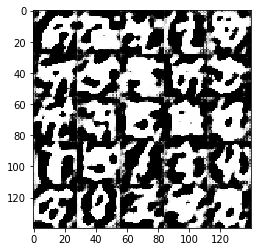

Epoch 1/2... Discriminator Loss: 0.7789... Generator Loss: 1.8151
Epoch 1/2... Discriminator Loss: 2.9711... Generator Loss: 4.3584
Epoch 1/2... Discriminator Loss: 1.7549... Generator Loss: 0.2507
Epoch 1/2... Discriminator Loss: 1.2076... Generator Loss: 3.5298
Epoch 1/2... Discriminator Loss: 1.0398... Generator Loss: 0.5683
Epoch 1/2... Discriminator Loss: 1.1902... Generator Loss: 0.4629
Epoch 1/2... Discriminator Loss: 0.6168... Generator Loss: 1.7464
Epoch 1/2... Discriminator Loss: 1.0185... Generator Loss: 0.8708
Epoch 1/2... Discriminator Loss: 1.2359... Generator Loss: 1.3908
Epoch 1/2... Discriminator Loss: 1.6357... Generator Loss: 0.2712


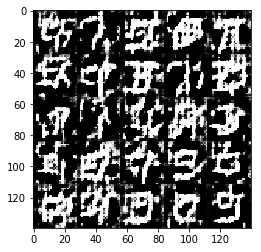

Epoch 1/2... Discriminator Loss: 1.3768... Generator Loss: 0.5649
Epoch 1/2... Discriminator Loss: 1.6290... Generator Loss: 0.3365
Epoch 1/2... Discriminator Loss: 2.2005... Generator Loss: 0.1569
Epoch 1/2... Discriminator Loss: 1.3887... Generator Loss: 0.3790
Epoch 1/2... Discriminator Loss: 0.8192... Generator Loss: 1.0421
Epoch 1/2... Discriminator Loss: 1.0918... Generator Loss: 0.5710
Epoch 1/2... Discriminator Loss: 1.2324... Generator Loss: 1.6693
Epoch 1/2... Discriminator Loss: 0.8107... Generator Loss: 0.7744
Epoch 1/2... Discriminator Loss: 0.7630... Generator Loss: 1.4477
Epoch 1/2... Discriminator Loss: 1.2444... Generator Loss: 0.4709


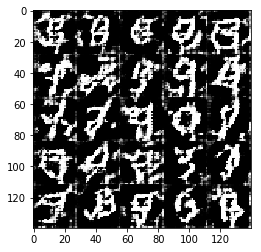

Epoch 1/2... Discriminator Loss: 0.8441... Generator Loss: 0.7386
Epoch 1/2... Discriminator Loss: 0.8210... Generator Loss: 0.8551
Epoch 1/2... Discriminator Loss: 0.6037... Generator Loss: 1.6181
Epoch 1/2... Discriminator Loss: 3.1195... Generator Loss: 0.0666
Epoch 1/2... Discriminator Loss: 0.9748... Generator Loss: 0.6738
Epoch 1/2... Discriminator Loss: 1.0893... Generator Loss: 0.5714
Epoch 1/2... Discriminator Loss: 0.5615... Generator Loss: 1.1632
Epoch 1/2... Discriminator Loss: 0.4507... Generator Loss: 1.5128
Epoch 1/2... Discriminator Loss: 0.7772... Generator Loss: 0.8341
Epoch 1/2... Discriminator Loss: 0.9253... Generator Loss: 0.6955


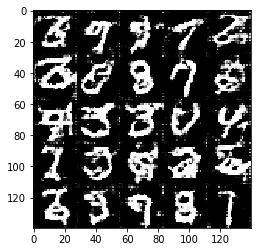

Epoch 1/2... Discriminator Loss: 1.0363... Generator Loss: 0.5539
Epoch 1/2... Discriminator Loss: 0.9422... Generator Loss: 0.7599
Epoch 1/2... Discriminator Loss: 1.0697... Generator Loss: 0.5395
Epoch 1/2... Discriminator Loss: 0.6228... Generator Loss: 1.1340
Epoch 1/2... Discriminator Loss: 0.7399... Generator Loss: 1.3788
Epoch 1/2... Discriminator Loss: 1.3541... Generator Loss: 0.3870
Epoch 1/2... Discriminator Loss: 0.5843... Generator Loss: 1.3467
Epoch 1/2... Discriminator Loss: 1.1739... Generator Loss: 1.9546
Epoch 1/2... Discriminator Loss: 2.4273... Generator Loss: 0.1140
Epoch 1/2... Discriminator Loss: 2.5337... Generator Loss: 0.1098


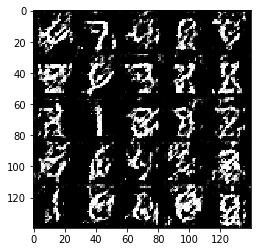

Epoch 1/2... Discriminator Loss: 0.8405... Generator Loss: 0.9960
Epoch 1/2... Discriminator Loss: 2.0302... Generator Loss: 0.1754
Epoch 1/2... Discriminator Loss: 0.7876... Generator Loss: 0.7642
Epoch 1/2... Discriminator Loss: 1.3070... Generator Loss: 0.4499
Epoch 1/2... Discriminator Loss: 1.8881... Generator Loss: 0.2348
Epoch 1/2... Discriminator Loss: 0.3001... Generator Loss: 1.6366
Epoch 1/2... Discriminator Loss: 0.2461... Generator Loss: 1.9251
Epoch 1/2... Discriminator Loss: 0.6151... Generator Loss: 0.9714
Epoch 1/2... Discriminator Loss: 1.1351... Generator Loss: 1.1213
Epoch 1/2... Discriminator Loss: 0.8427... Generator Loss: 0.8202


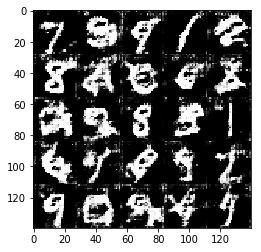

Epoch 1/2... Discriminator Loss: 1.0667... Generator Loss: 1.5677
Epoch 1/2... Discriminator Loss: 1.1781... Generator Loss: 0.8005
Epoch 1/2... Discriminator Loss: 2.3110... Generator Loss: 0.1409
Epoch 1/2... Discriminator Loss: 0.9567... Generator Loss: 0.7115
Epoch 1/2... Discriminator Loss: 0.8652... Generator Loss: 0.7625
Epoch 1/2... Discriminator Loss: 0.9566... Generator Loss: 0.8261
Epoch 1/2... Discriminator Loss: 1.1380... Generator Loss: 0.4969
Epoch 1/2... Discriminator Loss: 2.8093... Generator Loss: 0.0995
Epoch 1/2... Discriminator Loss: 0.9164... Generator Loss: 0.7678
Epoch 1/2... Discriminator Loss: 3.0030... Generator Loss: 0.0887


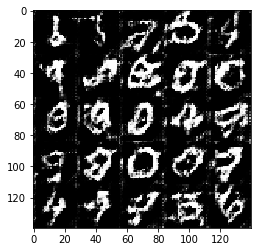

Epoch 1/2... Discriminator Loss: 1.2008... Generator Loss: 0.4798
Epoch 1/2... Discriminator Loss: 0.4879... Generator Loss: 3.0067
Epoch 1/2... Discriminator Loss: 0.6136... Generator Loss: 0.9786
Epoch 1/2... Discriminator Loss: 0.6547... Generator Loss: 1.3572
Epoch 1/2... Discriminator Loss: 1.8870... Generator Loss: 0.2243
Epoch 1/2... Discriminator Loss: 0.9435... Generator Loss: 0.6441
Epoch 1/2... Discriminator Loss: 0.7462... Generator Loss: 0.9116
Epoch 1/2... Discriminator Loss: 0.6658... Generator Loss: 0.8681
Epoch 1/2... Discriminator Loss: 0.4548... Generator Loss: 1.2436
Epoch 1/2... Discriminator Loss: 2.2467... Generator Loss: 0.1911


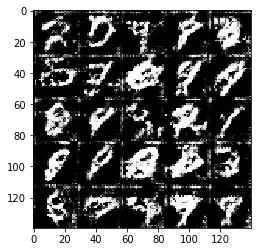

Epoch 1/2... Discriminator Loss: 1.2339... Generator Loss: 1.1930
Epoch 1/2... Discriminator Loss: 1.4408... Generator Loss: 2.7472
Epoch 1/2... Discriminator Loss: 0.9939... Generator Loss: 0.6177
Epoch 2/2... Discriminator Loss: 1.9463... Generator Loss: 0.2430
Epoch 2/2... Discriminator Loss: 1.1358... Generator Loss: 3.0482
Epoch 2/2... Discriminator Loss: 1.4180... Generator Loss: 0.3905
Epoch 2/2... Discriminator Loss: 0.6550... Generator Loss: 1.2330
Epoch 2/2... Discriminator Loss: 0.6644... Generator Loss: 0.8610
Epoch 2/2... Discriminator Loss: 0.7593... Generator Loss: 0.8049
Epoch 2/2... Discriminator Loss: 2.9591... Generator Loss: 7.0034


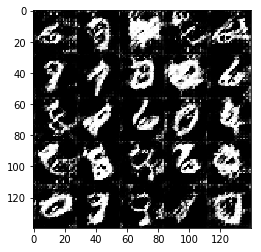

Epoch 2/2... Discriminator Loss: 0.6334... Generator Loss: 1.8519
Epoch 2/2... Discriminator Loss: 0.4169... Generator Loss: 1.4264
Epoch 2/2... Discriminator Loss: 0.7784... Generator Loss: 0.8016
Epoch 2/2... Discriminator Loss: 0.7706... Generator Loss: 1.6044
Epoch 2/2... Discriminator Loss: 1.1573... Generator Loss: 0.5092
Epoch 2/2... Discriminator Loss: 2.1959... Generator Loss: 0.1794
Epoch 2/2... Discriminator Loss: 0.6730... Generator Loss: 0.8978
Epoch 2/2... Discriminator Loss: 0.1017... Generator Loss: 2.8585
Epoch 2/2... Discriminator Loss: 0.1195... Generator Loss: 2.8231
Epoch 2/2... Discriminator Loss: 0.1578... Generator Loss: 2.4266


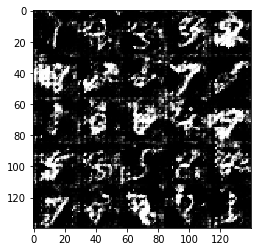

Epoch 2/2... Discriminator Loss: 0.0829... Generator Loss: 3.0755
Epoch 2/2... Discriminator Loss: 0.4833... Generator Loss: 1.1276
Epoch 2/2... Discriminator Loss: 1.3609... Generator Loss: 0.4073
Epoch 2/2... Discriminator Loss: 0.5544... Generator Loss: 1.0294
Epoch 2/2... Discriminator Loss: 0.1360... Generator Loss: 2.3542
Epoch 2/2... Discriminator Loss: 0.0984... Generator Loss: 2.8235
Epoch 2/2... Discriminator Loss: 0.4327... Generator Loss: 1.2526
Epoch 2/2... Discriminator Loss: 2.9857... Generator Loss: 0.2180
Epoch 2/2... Discriminator Loss: 1.1145... Generator Loss: 1.2444
Epoch 2/2... Discriminator Loss: 1.0294... Generator Loss: 1.1254


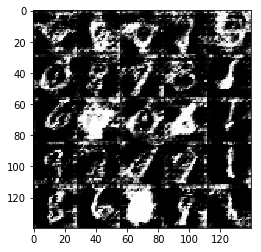

Epoch 2/2... Discriminator Loss: 0.7389... Generator Loss: 1.2234
Epoch 2/2... Discriminator Loss: 1.4762... Generator Loss: 1.9294
Epoch 2/2... Discriminator Loss: 1.1756... Generator Loss: 0.7744
Epoch 2/2... Discriminator Loss: 0.9949... Generator Loss: 0.8862
Epoch 2/2... Discriminator Loss: 0.7518... Generator Loss: 0.9392
Epoch 2/2... Discriminator Loss: 1.4636... Generator Loss: 0.3584
Epoch 2/2... Discriminator Loss: 2.4817... Generator Loss: 0.1216
Epoch 2/2... Discriminator Loss: 1.2680... Generator Loss: 0.4549
Epoch 2/2... Discriminator Loss: 0.5380... Generator Loss: 1.0537
Epoch 2/2... Discriminator Loss: 1.2907... Generator Loss: 0.3844


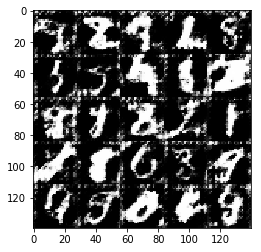

Epoch 2/2... Discriminator Loss: 1.1607... Generator Loss: 0.4538
Epoch 2/2... Discriminator Loss: 0.9464... Generator Loss: 0.6304
Epoch 2/2... Discriminator Loss: 1.0199... Generator Loss: 0.5904
Epoch 2/2... Discriminator Loss: 1.3158... Generator Loss: 0.4657
Epoch 2/2... Discriminator Loss: 0.5794... Generator Loss: 1.0379
Epoch 2/2... Discriminator Loss: 0.5094... Generator Loss: 1.0724
Epoch 2/2... Discriminator Loss: 2.3662... Generator Loss: 5.6091
Epoch 2/2... Discriminator Loss: 1.8676... Generator Loss: 0.2343
Epoch 2/2... Discriminator Loss: 1.0594... Generator Loss: 1.1356
Epoch 2/2... Discriminator Loss: 1.3837... Generator Loss: 0.3850


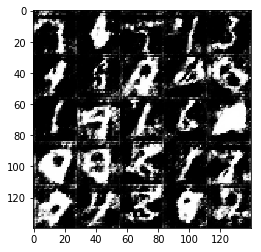

Epoch 2/2... Discriminator Loss: 0.9582... Generator Loss: 0.6272
Epoch 2/2... Discriminator Loss: 0.7927... Generator Loss: 0.7506
Epoch 2/2... Discriminator Loss: 1.4982... Generator Loss: 0.3205
Epoch 2/2... Discriminator Loss: 3.4613... Generator Loss: 0.0493
Epoch 2/2... Discriminator Loss: 2.3133... Generator Loss: 0.1410
Epoch 2/2... Discriminator Loss: 0.3216... Generator Loss: 1.6212
Epoch 2/2... Discriminator Loss: 0.1901... Generator Loss: 2.1033
Epoch 2/2... Discriminator Loss: 1.1891... Generator Loss: 0.6363
Epoch 2/2... Discriminator Loss: 0.5202... Generator Loss: 1.7793
Epoch 2/2... Discriminator Loss: 1.0407... Generator Loss: 0.5390


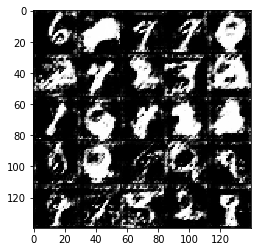

Epoch 2/2... Discriminator Loss: 3.2370... Generator Loss: 0.0552
Epoch 2/2... Discriminator Loss: 1.2072... Generator Loss: 0.4445
Epoch 2/2... Discriminator Loss: 0.7518... Generator Loss: 1.0159
Epoch 2/2... Discriminator Loss: 0.7930... Generator Loss: 0.7286
Epoch 2/2... Discriminator Loss: 0.5732... Generator Loss: 1.0515
Epoch 2/2... Discriminator Loss: 0.1849... Generator Loss: 2.0344
Epoch 2/2... Discriminator Loss: 1.0927... Generator Loss: 0.4786
Epoch 2/2... Discriminator Loss: 0.2084... Generator Loss: 2.0645
Epoch 2/2... Discriminator Loss: 0.3012... Generator Loss: 1.5815
Epoch 2/2... Discriminator Loss: 0.9017... Generator Loss: 0.6082


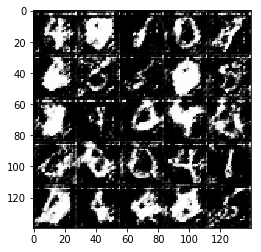

Epoch 2/2... Discriminator Loss: 0.4178... Generator Loss: 1.3552
Epoch 2/2... Discriminator Loss: 0.1979... Generator Loss: 1.9629
Epoch 2/2... Discriminator Loss: 0.3416... Generator Loss: 1.5160
Epoch 2/2... Discriminator Loss: 1.0425... Generator Loss: 0.5708
Epoch 2/2... Discriminator Loss: 0.2666... Generator Loss: 1.7765
Epoch 2/2... Discriminator Loss: 0.5355... Generator Loss: 1.0627
Epoch 2/2... Discriminator Loss: 0.3121... Generator Loss: 2.4930
Epoch 2/2... Discriminator Loss: 0.3450... Generator Loss: 1.7715
Epoch 2/2... Discriminator Loss: 0.8207... Generator Loss: 0.7527
Epoch 2/2... Discriminator Loss: 0.9022... Generator Loss: 0.6607


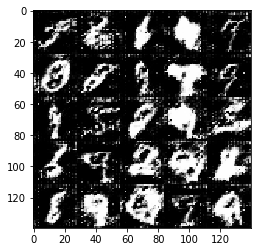

Epoch 2/2... Discriminator Loss: 0.2969... Generator Loss: 1.5837
Epoch 2/2... Discriminator Loss: 0.5126... Generator Loss: 1.2010
Epoch 2/2... Discriminator Loss: 0.2458... Generator Loss: 1.8123
Epoch 2/2... Discriminator Loss: 1.4395... Generator Loss: 0.3585
Epoch 2/2... Discriminator Loss: 0.9597... Generator Loss: 0.8166
Epoch 2/2... Discriminator Loss: 0.6608... Generator Loss: 1.0583
Epoch 2/2... Discriminator Loss: 0.9112... Generator Loss: 1.3661
Epoch 2/2... Discriminator Loss: 0.9064... Generator Loss: 0.6597
Epoch 2/2... Discriminator Loss: 0.5826... Generator Loss: 1.0324
Epoch 2/2... Discriminator Loss: 0.6603... Generator Loss: 0.9149


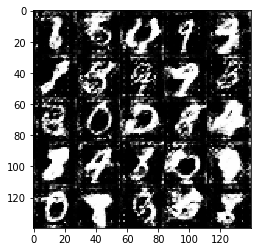

Epoch 2/2... Discriminator Loss: 0.4351... Generator Loss: 1.2684
Epoch 2/2... Discriminator Loss: 0.5078... Generator Loss: 1.0881
Epoch 2/2... Discriminator Loss: 0.2922... Generator Loss: 1.6405
Epoch 2/2... Discriminator Loss: 0.2147... Generator Loss: 2.0357
Epoch 2/2... Discriminator Loss: 0.4682... Generator Loss: 1.3056
Epoch 2/2... Discriminator Loss: 0.2312... Generator Loss: 1.7484
Epoch 2/2... Discriminator Loss: 0.4357... Generator Loss: 1.2035


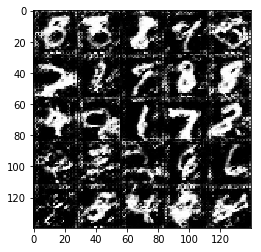

In [17]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.1728... Generator Loss: 0.6055
Epoch 1/1... Discriminator Loss: 1.1197... Generator Loss: 0.5637
Epoch 1/1... Discriminator Loss: 1.0689... Generator Loss: 0.5613
Epoch 1/1... Discriminator Loss: 1.0421... Generator Loss: 0.5612
Epoch 1/1... Discriminator Loss: 1.0029... Generator Loss: 0.5707
Epoch 1/1... Discriminator Loss: 0.9868... Generator Loss: 0.5801
Epoch 1/1... Discriminator Loss: 1.0275... Generator Loss: 0.5449
Epoch 1/1... Discriminator Loss: 1.0945... Generator Loss: 0.5155
Epoch 1/1... Discriminator Loss: 1.1856... Generator Loss: 0.4850
Epoch 1/1... Discriminator Loss: 1.0958... Generator Loss: 0.5600


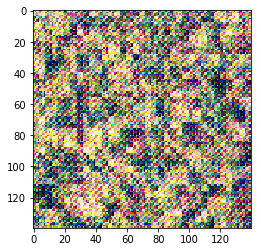

Epoch 1/1... Discriminator Loss: 1.1071... Generator Loss: 0.5706
Epoch 1/1... Discriminator Loss: 1.1096... Generator Loss: 0.5997
Epoch 1/1... Discriminator Loss: 1.0915... Generator Loss: 0.6317
Epoch 1/1... Discriminator Loss: 1.1908... Generator Loss: 0.5887
Epoch 1/1... Discriminator Loss: 1.1209... Generator Loss: 0.6878
Epoch 1/1... Discriminator Loss: 1.1636... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.1245... Generator Loss: 0.7039
Epoch 1/1... Discriminator Loss: 1.1785... Generator Loss: 0.6659
Epoch 1/1... Discriminator Loss: 1.1863... Generator Loss: 0.7407
Epoch 1/1... Discriminator Loss: 1.1967... Generator Loss: 0.7525


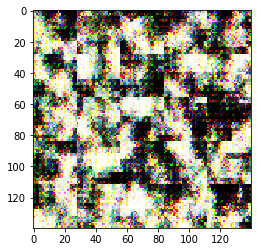

Epoch 1/1... Discriminator Loss: 1.2270... Generator Loss: 0.7339
Epoch 1/1... Discriminator Loss: 1.1577... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 1.2271... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.1920... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 0.7170
Epoch 1/1... Discriminator Loss: 1.2940... Generator Loss: 0.6896
Epoch 1/1... Discriminator Loss: 1.2887... Generator Loss: 0.7453
Epoch 1/1... Discriminator Loss: 1.2730... Generator Loss: 0.7411
Epoch 1/1... Discriminator Loss: 1.2656... Generator Loss: 0.7394
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.7210


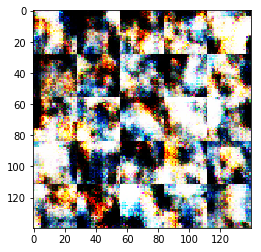

Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 0.7044
Epoch 1/1... Discriminator Loss: 1.3606... Generator Loss: 0.6989
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.7250
Epoch 1/1... Discriminator Loss: 1.3394... Generator Loss: 0.7246
Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 0.6748
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.6774
Epoch 1/1... Discriminator Loss: 1.3447... Generator Loss: 0.6714
Epoch 1/1... Discriminator Loss: 1.3088... Generator Loss: 0.6837
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.6526


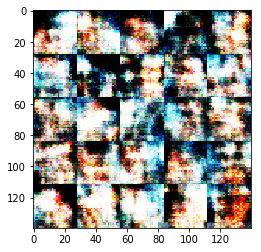

Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.6739
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.6551
Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 0.6694
Epoch 1/1... Discriminator Loss: 1.3008... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.6564
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.6379
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.6533
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.6797
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.6454
Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 0.6608


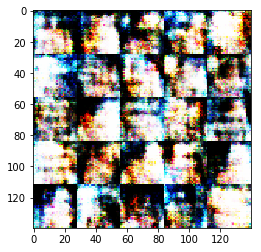

Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.6461
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.6405
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.6373
Epoch 1/1... Discriminator Loss: 1.4428... Generator Loss: 0.6308
Epoch 1/1... Discriminator Loss: 1.4336... Generator Loss: 0.6304
Epoch 1/1... Discriminator Loss: 1.4792... Generator Loss: 0.6154
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.6437
Epoch 1/1... Discriminator Loss: 1.4716... Generator Loss: 0.6265
Epoch 1/1... Discriminator Loss: 1.4821... Generator Loss: 0.6243


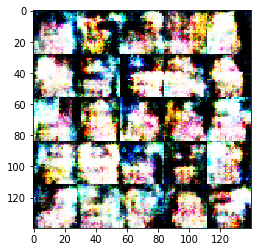

Epoch 1/1... Discriminator Loss: 1.4557... Generator Loss: 0.6344
Epoch 1/1... Discriminator Loss: 1.5003... Generator Loss: 0.6073
Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 0.6376
Epoch 1/1... Discriminator Loss: 1.4925... Generator Loss: 0.6343
Epoch 1/1... Discriminator Loss: 1.4758... Generator Loss: 0.6138
Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.6473
Epoch 1/1... Discriminator Loss: 1.4708... Generator Loss: 0.6014
Epoch 1/1... Discriminator Loss: 1.4511... Generator Loss: 0.6343
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.6654
Epoch 1/1... Discriminator Loss: 1.4757... Generator Loss: 0.6365


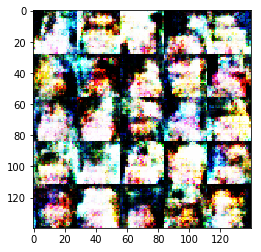

Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.6487
Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 0.6516
Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.6324


KeyboardInterrupt: 

In [48]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.